<a href="https://colab.research.google.com/github/KyubumShin/DL_Practice/blob/main/Transfer_Learning_ver_Pytroch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 다운로드

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shinkyubum","key":"9c775b5c89b7d3a836bd1a817c25800a"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

100% 7.25G/7.25G [01:21<00:00, 68.9MB/s]
100% 7.25G/7.25G [01:21<00:00, 95.8MB/s]


In [ ]:
!unzip diabetic-retinopathy-resized.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: resized_train_cropped/resized_train_cropped/44260_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44261_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44261_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44262_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44262_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44263_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44263_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44264_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44264_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44265_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44265_right.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/44267_left.jpeg  
  inflating: resized_train_cropped/resized_train_cropped/4

## Lib import

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
import pandas as pd

plt.ion()

In [ ]:
dataset = pd.read_csv('trainLabels_cropped.csv')

In [ ]:
dataset.head()

,Unnamed: 0,Unnamed: 0.1,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1


In [ ]:
!mkdir train/4

### 데이터셋 클래스별 폴더로 이동

In [ ]:
before_path = "/content/resized_train/resized_train"
after_path = "/content/train"

for item in dataset.loc():
    shutil.move(os.path.join(before_path, item.image + ".jpeg"), os.path.join(after_path, str(item.level)))

KeyError: ignored

## 데이터셋 전처리

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = '/content/train2'
image_datasets = datasets.ImageFolder(os.path.join(data_dir), data_transforms["train"])

### 데이터셋을 train set과 val set으로 랜덤 분류

In [ ]:
dataset_size = len(image_datasets)
data_Index = list(range(0,dataset_size-1))
random.shuffle(data_Index)
train_indice = data_Index[0:int(dataset_size * 0.8)]
val_indice = data_Index[int(dataset_size * 0.8):dataset_size-1]
train_set = torch.utils.data.Subset(image_datasets, train_indice)
val_set = torch.utils.data.Subset(image_datasets, val_indice)

In [ ]:
train_size = len(train_set)
val_size = len(val_set)
dataset_sizes = {}
dataset_sizes['train'], dataset_sizes['val'] = train_size, val_size
dataset_sizes

{'train': 28086, 'val': 7021}

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
class_names = image_datasets.classes
class_names

['level0', 'level1', 'level2', 'level3', 'level4']

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

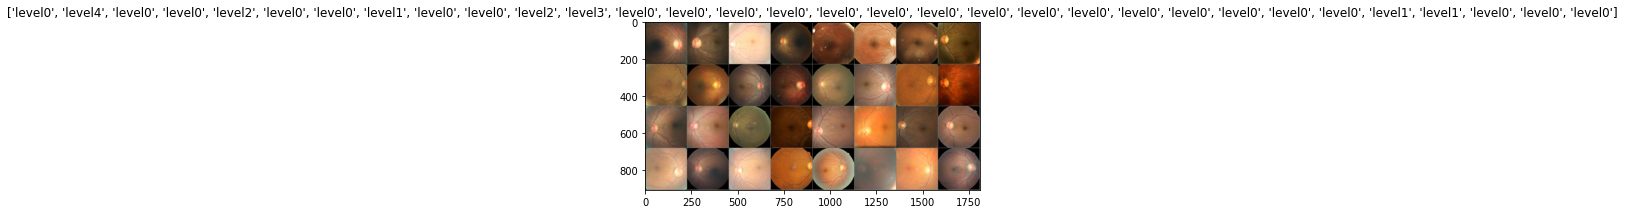

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(val_loader))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 전이학습 관련 함수 정의

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
                data = train_loader
            else:
                model.eval()   # 모델을 평가 모드로 설정
                data = val_loader

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in data:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

## 결과를 보기위한 visualize_model 정의

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            
        model.train(mode=was_training)

## 학습

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.7612 Acc: 0.7482
val Loss: 0.7387 Acc: 0.7611

Epoch 1/14
----------
train Loss: 0.6427 Acc: 0.7789
val Loss: 0.6662 Acc: 0.7717

Epoch 2/14
----------
train Loss: 0.5681 Acc: 0.8037
val Loss: 0.6918 Acc: 0.7734

Epoch 3/14
----------
train Loss: 0.4822 Acc: 0.8296
val Loss: 0.7296 Acc: 0.7606

Epoch 4/14
----------
train Loss: 0.3831 Acc: 0.8620
val Loss: 0.7784 Acc: 0.7441

Epoch 5/14
----------
train Loss: 0.2804 Acc: 0.8977
val Loss: 0.9130 Acc: 0.7449

Epoch 6/14
----------
train Loss: 0.1954 Acc: 0.9306
val Loss: 1.0648 Acc: 0.7616

Epoch 7/14
----------
train Loss: 0.0802 Acc: 0.9795
val Loss: 0.9891 Acc: 0.7620

Epoch 8/14
----------
train Loss: 0.0496 Acc: 0.9915
val Loss: 1.0321 Acc: 0.7690

Epoch 9/14
----------
train Loss: 0.0381 Acc: 0.9944
val Loss: 1.0492 Acc: 0.7677

Epoch 10/14
----------
train Loss: 0.0303 Acc: 0.9968
val Loss: 1.0497 Acc: 0.7623

Epoch 11/14
----------
train Loss: 0.0270 Acc: 0.9972
val Loss: 1.0907 Acc: 0.7677

Ep

## 결과

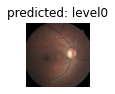

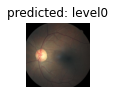

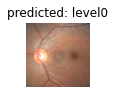

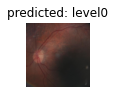

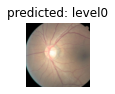

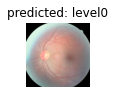

In [ ]:
visualize_model(model_ft)